In [1]:
import numpy as np
import random 
import matplotlib.pyplot as plt
import copy
from mpl_toolkits import mplot3d
import pandas as pd

In [14]:
real_infected = np.array([100,103,106,113,115,124,141,146,147,177,212,272,322,411,599,721,827,934,1045,1136,1245])
#df = pd.read_csv('out1.csv')
#real_infected=df['number of Infect'].values.tolist()
#real_infected=real_infected[10:]
date = np.arange(0,len(real_infected))
len(date)

21

In [3]:
############### Parameters ##########################
Pop        = 6E7
#length     = 20      # predicted length (days)
healed_day = 21     # infected people will be healed in 21 days after being infected

In [4]:
def model(f_rate, meeting, R, day_i, day_f, normal, infect, heal, net, found, plot=False, fit=True):
    ## model infection from day_i to day_f and calculate MAE 
    
    # Fitting parameters
    # f_rate      :found rate
    # meeting     :1 infected people can meet <meeting> people
    # R  :transfered rate
    # normal, infect, heal, net : day_i
    
    R_lst    = R # transfered rate
    if day_i == 0:
        day      = [0]
        init_infect = real_infected[0]/f_rate        # initial infected people
        #..............................#
        Normal   = [Pop-init_infect]       # never being infected
        Infect   = [init_infect]           # sum of being infected and used to
        Heal     = [0]                     # be healed
        Net      = [Infect[0] - Heal[0]]   # still being infected
        Found    = [init_infect*f_rate]    # infect * found_rate
        day_i = 1
    else:
        day   =list(range(day_i))
        Normal=copy.deepcopy(normal)
        Infect=copy.deepcopy(infect)
        Heal  =copy.deepcopy(heal)
        Net   =copy.deepcopy(net)
        Found =copy.deepcopy(found)
    
    #begin modeling
    for i in range(day_i,day_f+1):
        day.append(i)
        
        ### update total infected people
        new_infect = 0
        Rate  = R_lst*R_lst*meeting
        new_infect = new_infect + Rate*Net[-1]*Normal[-1]/Pop
        Infect.append(Infect[-1] + new_infect)

        ### update found people
        Found.append(Found[-1]+new_infect*f_rate)

        ### update normal people
        Normal.append(Normal[-1]-new_infect)

        ### update healed people
        if i < healed_day:
            new_healed = 0
        elif i == healed_day:
            new_healed = Infect[0]
        else:
            new_healed = Infect[-1-healed_day]-Infect[-1-healed_day-1]
        Heal.append(Heal[-1]+new_healed)

        ### update net
        Net.append(Infect[-1]-Heal[-1])
        ##print('day: %2d Normal: %10.1f Infected: %10.1f Healed: %10.1f Net: %10.1f //%10.1f' %(i,Normal[-1],Infect[-1],Heal[-1],Net[-1],new_infect))
        
    if plot==True:
        #plt.plot(day,Normal,'-',label ="Normal")
        #plt.plot(day,Infect,'-',label ="Infected")
        #plt.plot(day,Heal,'-',label ="Healed")
        #plt.plot(day,Net,'-',label ="Net")
        plt.plot(day,Found,'-',label ="Found")
        plt.plot(date,real_infected,'ro', label='real') 
        #plt.ylim([0,Found[-1]*1.2])
        #plt.xlim([0,day_f*1.2])
        plt.xlabel('day')
        plt.ylabel('people')
        plt.legend()
        plt.show()
    if fit == True:
        ### Calculate MAE
        AE=0
        for i in range(day_i,day_f+1):
            AE=AE+abs(Found[i]-real_infected[i])
        MAE = AE/(day_f-day_i+1)
        #print("%10.4f" %MAE)

        return MAE, Normal, Infect, Heal, Net, Found
    else:
        return Normal, Infect, Heal, Net, Found

In [5]:
### fitting from day_i to day_f
def fit(f_rate_s,meeting_s,R_s,day_i, day_f, CNormal, CInfect, CHeal, CNet, CFound):
    data = []
    for f_rate in f_rate_s:
        for meeting in meeting_s:
            for R in R_s:
                normal = copy.deepcopy(CNormal)
                infect = copy.deepcopy(CInfect)
                heal   = copy.deepcopy(CHeal)
                net    = copy.deepcopy(CNet)
                found  = copy.deepcopy(CFound)
                MAE, _, _, _, _, _ = model(f_rate, meeting, R, day_i, day_f,normal,infect,heal,net,found,plot=False,fit=True)
                #print('%6.2f %6.2f %4.1f %6.3f %6.3f %6.3f' %(MAE,f_rate,meeting,R))
                data.append([MAE, f_rate,meeting,R])
    sorted_data = sorted(data,key=lambda x: x[0])
    print('\nThe top 10 best fitted parameters')
    print('  MAE  f_rate Meeting  R')
    for i in range(10):
        print('%6.2f %6.2f %4.1f %6.3f' %(sorted_data[i][0],sorted_data[i][1],sorted_data[i][2],sorted_data[i][3]))
    print('\nPlotting for the best fitting')
    print('  MAE  f_rate Meeting  R')
    print('%6.2f %6.2f %4.1f %6.3f' %(sorted_data[0][0],sorted_data[0][1],sorted_data[0][2],sorted_data[0][3]))
    return sorted_data[0],model(sorted_data[0][1], sorted_data[0][2], sorted_data[0][3], day_i, day_f, CNormal, CInfect, CHeal, CNet, CFound, True, True)


The top 10 best fitted parameters
  MAE  f_rate Meeting  R
100.96   0.10 10.0  0.120
113.68   0.10 10.0  0.110
168.04   0.10 10.0  0.100
213.65   0.10 10.0  0.090
247.81   0.10 10.0  0.080
274.94   0.10 10.0  0.070
297.01   0.10 10.0  0.060
306.06   0.10 10.0  0.130
313.88   0.10 10.0  0.050
326.17   0.10 10.0  0.040

Plotting for the best fitting
  MAE  f_rate Meeting  R
100.96   0.10 10.0  0.120


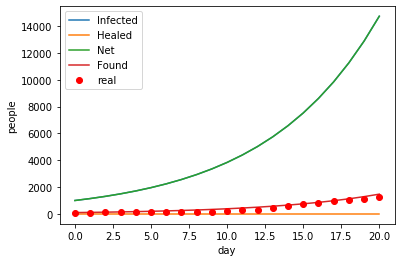

In [16]:
### Fitting
# fit(f_rate_s,meeting_s,Rh_s,Rm_s,Rr_s,day_i,day_f, Normal, Infect, Heal, Net, Found)

# step 1 day 0 to day 6
day_i = 0; day_f = 20
f_rate_s  = [0.1]
meeting_s = [10]
R_s       = np.arange(0.01,0.5,0.01)
params, [MAE, CNormal, CInfect, CHeal, CNet, CFound] = fit(f_rate_s,meeting_s,R_s,day_i,day_f, [], [], [], [],[])


[108.82190499997435, 0.1, 10, 0.14]


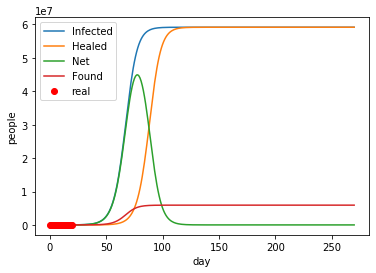

In [12]:
### prediction
day_i = 21; day_f = 270
print(params)
use_last_fitting = True   # True or False
if use_last_fitting:
    ### from last fitting
    f_rate = params[1]
    meeting= params[2]
    R      = params[3]

else:
    ### new input
    f_rate = 0.1
    meeting= 10
    R      = 0.08
_,_,_,_,_ = model(f_rate, meeting, R, day_i, day_f, CNormal, CInfect, CHeal, CNet, CFound, plot=True, fit=False)

